# Test A/B Analsys
### Kaggle's Dataset: https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing?resource=download

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

In [4]:
filepath = Path("marketing_AB.csv")
df = pd.read_csv(filepath)

In [5]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


## Exploration Analysis

In [ ]:
# unique counts
df.nunique()

Unnamed: 0       588101
user id          588101
test group            2
converted             2
total ads           807
most ads day          7
most ads hour        24
dtype: int64

In [7]:
# nulos por coluna
nulos = df.isna().sum().sort_values(ascending=False)
display(nulos.to_frame("n_nulos"))

,n_nulos
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


In [ ]:
# Duplicates
print("Duplicatas (linhas repetidas):", df.duplicated().sum())

Duplicatas (linhas repetidas): 0


In [ ]:
# Outliers 

num_cols = df.select_dtypes(include=[np.number]).columns  

def iqr_bounds(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1   
    return q1 - k*iqr, q3 + k*iqr  

outliers_info = {} 
for c in num_cols: 
    low, high = iqr_bounds(df[c].dropna()) 
    mask = (df[c] < low) | (df[c] > high) 
    outliers_info[c] = int(mask.sum()) 

pd.Series(outliers_info, name="n_outliers").sort_values(ascending=False)

total ads        52057
most ads hour     5536
Unnamed: 0           0
user id              0
Name: n_outliers, dtype: int64

In [ ]:
# Correlation (numbers)

corr = df[num_cols].corr()
corr.round(2)

,Unnamed: 0,user id,total ads,most ads hour
Unnamed: 0,1.000,-0.040,-0.390,0.010
user id,-0.040,1.000,0.010,-0.020
total ads,-0.390,0.010,1.000,-0.010
most ads hour,0.010,-0.020,-0.010,1.000


In [ ]:
# Group to categories and calculate metrics

resumo = df.groupby("test group")["total ads"].agg(["count", "mean", "median", "std", "max", "min"]).sort_values("count", ascending=False)
display(resumo.head(10))

,count,mean,median,std,max,min
test group,,,,,,
ad,564577,24.823,13.000,43.750,2065,1
psa,23524,24.761,12.000,42.861,907,1


In [ ]:
# Dinamic table

piv = pd.pivot_table(df, values="total ads", index="test group", columns="converted", aggfunc="mean")
display(piv)

converted,False,True
test group,,
ad,23.274,83.906
psa,23.697,83.276


## Visualizations

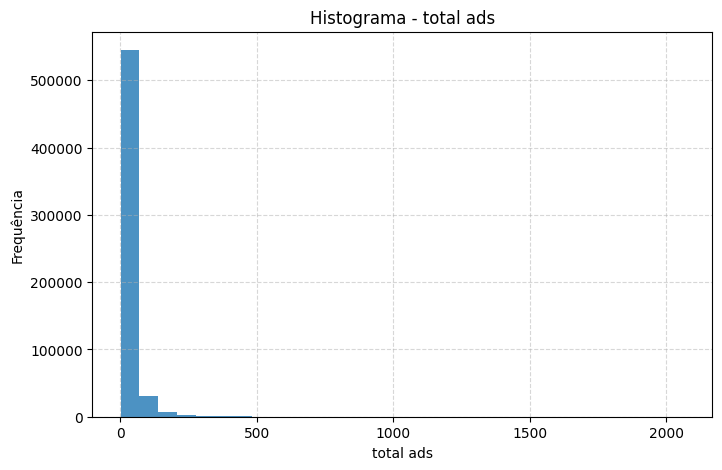

In [ ]:
#histogram
if "total ads" in df.columns:
    plt.figure(figsize=(8,5))  
    df["total ads"].plot(kind="hist", bins=30, alpha=0.8)
    plt.title("Histogram - total ads")
    plt.xlabel("total ads")      
    plt.ylabel("Frequence")     
    plt.grid(True, linestyle="--", alpha=0.5)  
    plt.show()
else:
    print("Column 'total ads' not found.")

## Boxplot

<Figure size 640x480 with 0 Axes>

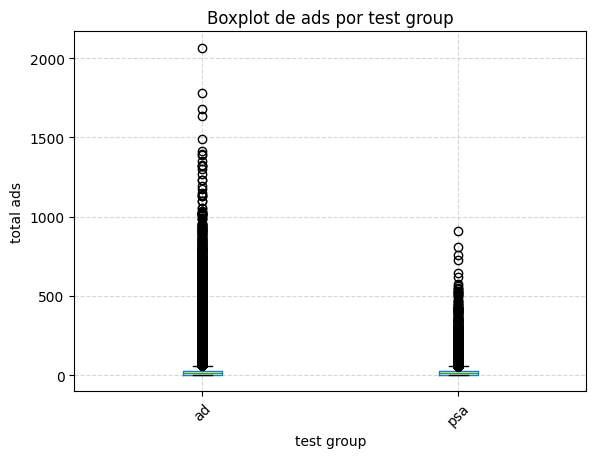

In [ ]:
# Boxplot 
plt.figure()
df.boxplot(column="total ads", by="test group", rot=45)
plt.title(f"Boxplot de ads by test group")
plt.suptitle("")
plt.xlabel("test group")
plt.ylabel("total ads")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## A/B Test 


In [16]:
df["test group"].value_counts()

test group
ad     564577
psa     23524
Name: count, dtype: int64

In [ ]:
conversion_rate = (
    df.groupby("test group")["converted"]
      .mean()
      .reset_index()
      .rename(columns={"converted": "conversion_rate"})
)
conversion_rate

,test group,conversion_rate
0,ad,0.026
1,psa,0.018


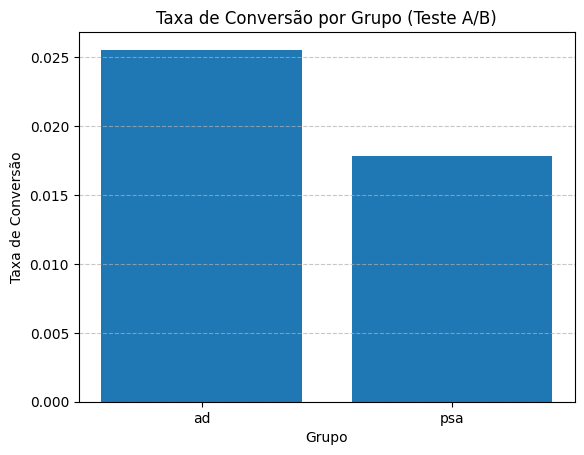

In [ ]:
# Grafic
plt.bar(conversion_rate["test group"], conversion_rate["conversion_rate"])
plt.title("Convertion by group ")
plt.xlabel("Grupo")
plt.ylabel("Convertion Tax")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Statistic test

In [ ]:

from scipy.stats import chi2_contingency

# contingence table
contingency = pd.crosstab(df["test group"], df["converted"])
chi2, p, dof, expected = chi2_contingency(contingency)
p

1.9989623063390075e-13

In [ ]:
contingency 

converted,False,True
test group,,
ad,550154,14423
psa,23104,420


In [ ]:
expected 

array([[550327.71899045,  14249.28100955],
       [ 22930.28100955,    593.71899045]])

### Interpretation

The chi-square test yielded a p-value of 1.99e-13, which is far below the 0.05 significance threshold.
Therefore, we reject the null hypothesis and conclude that the AD group’s conversion rate (2.62%) is significantly higher than the PSA group’s (1.82%).
This indicates that the test variation had a real, statistically significant impact on conversions.